---
**Project**: Submarine Route Constraints  
**Author**: Alejandra L. Cameselle  
**Date**: July 2025  
**Notebook**: 06 – Assign Exclusion Scores to Grid Cells

### Description  
This notebook assigns exclusion scores to each 100 m grid cell across the AOI based on spatial intersection with constraint layers. The scoring strategy combines a **hard exclusion rule** for critical constraints with a **soft risk accumulation model** for all other factors. The goal is to generate a final `exclusion_score` that clearly separates non-viable zones from high-, medium- and low-risk areas, ensuring interpretability for route engineers.

### Constraint Layers and Assigned Penalty Weights (`wᵢ`)
The following table summarizes all spatial constraint layers used in the exclusion scoring model, along with their assigned penalty weights (`wᵢ`). These weights reflect the relative importance of each constraint in route planning, based on engineering risk, legal priority, and operational difficulty.

| Constraint Layer                         | Description                                 | Weight (`wᵢ`) |
|------------------------------------------|---------------------------------------------|---------------|
| `telecom_cables_exclusion_zone_2WD`      | Hard exclusion: 2× water depth buffer       |   — *(veto)*  |
| `telecom_cables_exclusion_zone_3WD`      | Caution zone: 3× water depth buffer         |      95       |
| `rocky_outcrops_clipped_depth` (shallow) | Rocky seabed at depth < 1000 m              |      90       |
| `rocky_outcrops_clipped_depth` (deep)    | Rocky seabed at depth ≥ 1000 m              |      60       |
| `fishing_areas_clipped`                  | Trawling and protected fisheries            |      80       |
| `military_areas_clipped`                 | Naval or military use zones                 |      70       |
| `natura2000_clipped`                     | Natura 2000 environmental protection areas  |      80       |
| `wrecks_buffered_500m`                   | 500 m buffer around shipwrecks or obstacles |      90       |
| `coralligenous_outcrops_clipped`         | Sensitive coral or biogenic reef areas      |      70       |
| `fluid_emissions_clipped`                | Gas seeps, fluid discharge zones            |      40       |
| `pockmarks_buffered_500m`                | 500 m buffer around fluid depressions       |      30       |
| `mud_mounts_buffered_500m`               | 500 m buffer around mud volcanoes           |      30       |

**Note:**  
- The score `100` is assigned automatically to all cells intersecting the `2WD` buffer (veto rule).  
- The weights `wᵢ` are only accumulated in `raw_risk` for cells **not excluded** by the 2WD rule.  
- The total maximum weight \( W = \sum wᵢ \) is used to normalize soft scores to a range of [0, 90].

### Scoring Logic  
1. **Flag exclusion (hard constraint)**  
   Cells intersecting the 2× water depth cable buffer are marked with `flag_exclusion = True` and assigned `final_score = 100`.  
   This exclusion rule is **non-negotiable** in engineering terms, as it reflects international safety and separation guidelines established by the **ICPC (International Cable Protection Committee)**. Violating this constraint would invalidate the route from an operational and legal perspective.

2. **Raw risk accumulation (soft constraints)**  
   For all other constraint layers (e.g., 3×-WD buffer, rocky outcrops, fishing zones, Natura2000, wrecks, etc.), weighted penalties `w_i` are accumulated in `raw_risk` only for cells not already excluded.

3. **Normalization to 0–90 scale**  
   The maximum possible soft risk value \( W = \sum w_i \) is used to normalize `raw_risk`, such that `final_score = (raw_risk / W) × 90`.

4. **Final adjustment**  
   - Cells with `flag_exclusion = True` retain `final_score = 100`.  
   - All other cells receive a proportional score in the range [0, 90].

This method ensures that:
- **No combination of soft constraints can override the hard exclusion rule mandated by ICPC standards**.
- **Cells not excluded can be ranked meaningfully by their risk level**.
- The final score is both **mathematically robust** and **intuitively explainable** to non-technical stakeholders.

### Inputs  
- `01_grid_100m.gpkg`: Base grid with unique cell geometries  
- Cable buffer layers:
  - `04_cable_exclusion_zone_2WD.gpkg`  
  - `04_cable_exclusion_zone_3WD.gpkg`  
- Rocky outcrops with depth classification:
  - `03_rocky_outcrops_clipped_depth.gpkg`  
- Other thematic constraint layers:
  - `05_wrecks_buffered_500m.gpkg`  
  - `05_pockmarks_buffered_500m.gpkg`  
  - `05_mud_mounts_buffered_500m.gpkg`  
  - `fluid_emissions_clipped.gpkg`  
  - `fishing_areas_clipped.gpkg`  
  - `military_areas_clipped.gpkg`  
  - `natura2000_clipped.gpkg`  
  - `coralligenous_outcrops_clipped.gpkg`

### Processing  
- Initialize scoring columns (`flag_exclusion`, `raw_risk`, `final_score`)  
- Apply exclusion for 2×-WD buffer (flag + score = 100)  
- Accumulate weighted soft constraints in `raw_risk`  
- Normalize and assign `final_score` for non-excluded cells  
- Classify scores using QGIS-compatible bins and color palette  

### Outputs  
- `06_grid_constraint_scores.gpkg`: Final scored grid with hard exclusions and normalized soft risk  
- `06_exclusion_score_map.png`: Classified map of scores using Jenks breaks and matched color ramp

### Assumptions  
- All layers are in the same projected CRS  
- Grid resolution is 100 m  
- `"depth_category"` is available in rocky outcrops  
- 3WD buffer excludes overlap with 2WD  
- Buffers for point hazards (500 m) are used only as a **project-specific simplification**  
- Constraint weights are defined and explained in `00_exclusion_layers_priority_matrix.md`  

### Dependencies  
- `geopandas`, `pandas`, `matplotlib`, `shapely`
---

In [1]:
import os
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.patches import Patch

In [2]:
# Load base grid and constraint layers

# Load base grid with unique cell IDs
grid = gpd.read_file("../processed_data/01_grid_100m.gpkg")

# Load all constraint layers into a dictionary
layers = {
    "wrecks": gpd.read_file("../processed_data/05_wrecks_buffered_500m.gpkg"),
    "coralligenous_outcrops": gpd.read_file("../processed_data/constraints/coralligenous_outcrops_clipped.gpkg"),
    "pockmarks": gpd.read_file("../processed_data/05_pockmarks_buffered_500m.gpkg"),
    "mud_mounts": gpd.read_file("../processed_data/05_mud_mounts_buffered_500m.gpkg"),
    "fluid_emissions": gpd.read_file("../processed_data/constraints/fluid_emissions_clipped.gpkg"),
    "fishing_areas": gpd.read_file("../processed_data/constraints/fishing_areas_clipped.gpkg"),
    "military_areas": gpd.read_file("../processed_data/constraints/military_areas_clipped.gpkg"),
    "natura2000": gpd.read_file("../processed_data/constraints/natura2000_clipped.gpkg"),
    "rocky_outcrops": gpd.read_file("../processed_data/03_rocky_outcrops_clipped_depth.gpkg"),  # special case
    "telecom_cables_exclusion_zone_3WD": gpd.read_file("../processed_data/04_cable_exclusion_zone_3WD.gpkg"),
    "telecom_cables_exclusion_zone_2WD": gpd.read_file("../processed_data/04_cable_exclusion_zone_2WD.gpkg")
}

In [3]:
# Define exclusion score dictionary (0–100 scale)

# Values based on prioritization matrix
score_dict = {
    "wrecks": 90,
    "coralligenous_outcrops": 70,
    "pockmarks": 30,
    "mud_mounts": 30,
    "fluid_emissions": 40,
    "fishing_areas": 80,
    "military_areas": 70,
    "natura2000": 80,
    "rocky_outcrops": { "shallow": 90, "deep": 60 },  # based on depth
    "telecom_cables_exclusion_zone_3WD": 95,
    "telecom_cables_exclusion_zone_2WD": 100
}

In [4]:
# Initialize hybrid scoring fields
# Create flag for hard exclusion (2WD) and cumulative risk score for soft constraints
grid_scores = grid.copy()
if 'flag_exclusion' not in grid_scores.columns:
    grid_scores['flag_exclusion'] = False  # True = fails hard exclusion (2× water depth)
if 'risk_score' not in grid_scores.columns:
    grid_scores['risk_score'] = 0          # cumulative score for soft constraints

# Ensure grid has a unique index for joins
grid_scores = grid_scores.reset_index(drop=True)

In [5]:
# Hybrid scoring with hard exclusions at 100 and soft‐risks normalized to 0–90

from pathlib import Path

# Prepare fields for risk accumulation and final score
grid_scores['raw_risk'] = 0.0       # will accumulate soft penalties
grid_scores['final_score'] = 0.0    # will store the 0–90 (soft) or 100 (hard)

# Compute total weight W for all soft constraints (excluding 2×WD)
W = 0
for layer_name, score in score_dict.items():
    if layer_name == "telecom_cables_exclusion_zone_2WD":
        continue
    if layer_name == "rocky_outcrops":
        W += sum(score.values())  # shallow + deep
    else:
        W += score

# Hard exclusion: any cell intersecting 2×WD gets final_score = 100
two_gdf = gpd.read_file("../processed_data/04_cable_exclusion_zone_2WD.gpkg")
two_gdf["geometry"] = two_gdf.geometry.simplify(tolerance=20, preserve_topology=True)
_ = two_gdf.sindex

joined2 = gpd.sjoin(grid_scores, two_gdf, how="left", predicate="intersects")
hits2 = joined2[~joined2["index_right"].isna()].index

# Assign flag and hard exclusion score
grid_scores.loc[hits2, "flag_exclusion"] = True
grid_scores.loc[hits2, "final_score"] = 100

# Soft-risk accumulation for non-excluded cells
for layer_name, score in score_dict.items():
    if layer_name == "telecom_cables_exclusion_zone_2WD":
        continue  # already handled

    # Load and prepare constraint geometry
    if layer_name == "telecom_cables_exclusion_zone_3WD":
        gdf = gpd.read_file("../processed_data/04_cable_exclusion_zone_3WD.gpkg")
        gdf["geometry"] = gdf.geometry.simplify(tolerance=20, preserve_topology=True)
        # Subtract 2× buffer to avoid double penalization
        union2 = two_gdf.geometry.union_all()
        union3 = gdf.geometry.union_all()
        diff_geom = union3.difference(union2)
        constraint_gdf = gpd.GeoDataFrame({"geometry": [diff_geom]}, crs=gdf.crs)
        weight = score

    elif layer_name == "rocky_outcrops":
        constraint_gdf = gpd.read_file("../processed_data/03_rocky_outcrops_clipped_depth.gpkg")
        constraint_gdf["geometry"] = constraint_gdf.geometry.simplify(tolerance=20, preserve_topology=True)

    else:
        # Custom path for point-based constraint buffers
        if layer_name == "wrecks":
            path = Path("../processed_data/05_wrecks_buffered_500m.gpkg")
        elif layer_name == "pockmarks":
            path = Path("../processed_data/05_pockmarks_buffered_500m.gpkg")
        elif layer_name == "mud_mounts":
            path = Path("../processed_data/05_mud_mounts_buffered_500m.gpkg")
        else:
            path = Path(f"../processed_data/constraints/{layer_name}_clipped.gpkg")

        # Specify layer name explicitly for geopackages with multiple layers
        if path.suffix == ".gpkg" and "05_" in path.name:
            constraint_gdf = gpd.read_file(path, layer=path.stem)
        else:
            constraint_gdf = gpd.read_file(path)

        constraint_gdf["geometry"] = constraint_gdf.geometry.simplify(tolerance=20, preserve_topology=True)
        weight = score

    _ = constraint_gdf.sindex

    if layer_name == "rocky_outcrops":
        # Separate scoring per depth category
        for subclass, sub_weight in score.items():
            sub_gdf = constraint_gdf[constraint_gdf["depth_category"] == subclass]
            _ = sub_gdf.sindex
            joined_sub = gpd.sjoin(grid_scores, sub_gdf, how="left", predicate="intersects")
            hits_sub = joined_sub[~joined_sub["index_right"].isna()].index
            valid_sub = [i for i in hits_sub if not grid_scores.at[i, "flag_exclusion"]]
            grid_scores.loc[valid_sub, "raw_risk"] += sub_weight

    else:
        # Uniform score applied to intersecting cells
        joined = gpd.sjoin(grid_scores, constraint_gdf, how="left", predicate="intersects")
        hits = joined[~joined["index_right"].isna()].index
        valid_hits = [i for i in hits if not grid_scores.at[i, "flag_exclusion"]]
        grid_scores.loc[valid_hits, "raw_risk"] += weight

# Normalize soft risk to range [0–90]
mask = ~grid_scores["flag_exclusion"]
grid_scores.loc[mask, "final_score"] = (grid_scores.loc[mask, "raw_risk"] / W) * 90

# Ensure final scores are capped at 100
grid_scores["final_score"] = grid_scores["final_score"].clip(upper=100)

In [6]:
# Clip scored grid by Area of Interest (AOI)

# Load AOI polygon
aoi = gpd.read_file("../inputs/aoi.gpkg")

# Ensure the AOI uses the same CRS as grid_scores
if aoi.crs != grid_scores.crs:
    aoi = aoi.to_crs(grid_scores.crs)

# Perform the clip
grid_clipped = gpd.clip(grid_scores, aoi)

# Reset index for a clean GeoDataFrame
grid_clipped = grid_clipped.reset_index(drop=True)

In [7]:
# Save hybrid scoring results to GeoPackage

# Save grid_scores, including 'flag_exclusion' and 'risk_score'
out_path = "../processed_data/06_grid_constraint_scores.gpkg"
grid_clipped.to_file(out_path, driver="GPKG")

print(f"Hybrid scoring results saved to: {out_path}")

Hybrid scoring results saved to: ../processed_data/06_grid_constraint_scores.gpkg


Map saved to: ../outputs/plots/06_exclusion_score_map.png


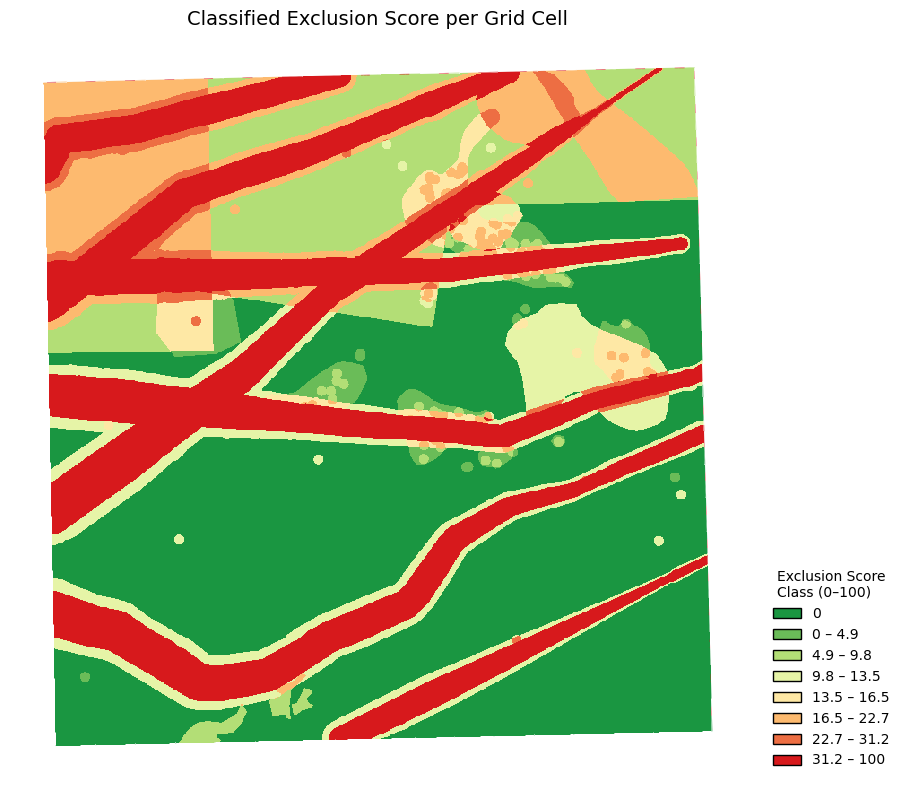

In [8]:
# Classification-based visualization

# Define class breaks and labels (based on QGIS)
bins = [-0.01, 0.0, 4.898, 9.796, 13.469, 16.531, 22.653, 31.224, 100.0]
labels = [
    "0",          # covers score == 0
    "0 – 4.9",
    "4.9 – 9.8",
    "9.8 – 13.5",
    "13.5 – 16.5",
    "16.5 – 22.7",
    "22.7 – 31.2",
    "31.2 – 100"
]

# Define corresponding hex colors (from QGIS style)
hex_colors = [
    "#1A9641", "#6ABC58", "#B3DE76", "#E6F4A7",
    "#FEE8A5", "#FDBA6F", "#ED6E43", "#D7191C"
]
# Convert hex to RGBA
rgba_colors = [mcolors.to_rgba(c) for c in hex_colors]

# Classify grid cells
grid_clipped["class_idx"] = pd.cut(
    grid_clipped["final_score"],
    bins=bins,
    labels=range(len(labels)),
    include_lowest=True,
    right=True
).astype("Int64")

# Assign color per class
color_map = {i: rgba_colors[i] for i in range(len(labels))}
grid_clipped["plot_color"] = grid_clipped["class_idx"].map(color_map)

# Prepare plot
plot_dir = "../outputs/plots"
os.makedirs(plot_dir, exist_ok=True)
fig, ax = plt.subplots(figsize=(10, 8))

# Plot cells
grid_clipped.plot(
    color=grid_clipped["plot_color"],
    linewidth=0,
    ax=ax
)

# Legend
legend_handles = [
    Patch(facecolor=rgba_colors[i], edgecolor="black", label=labels[i])
    for i in range(len(labels))
]
ax.legend(
    handles=legend_handles,
    title="Exclusion Score\nClass (0–100)",
    bbox_to_anchor=(1.02, 0),
    loc="lower left",
    frameon=False
)

ax.set_title("Classified Exclusion Score per Grid Cell", fontsize=14)
ax.set_axis_off()
plt.tight_layout()

# Save output
out_path = os.path.join(plot_dir, "06_exclusion_score_map.png")
plt.savefig(out_path, dpi=300, bbox_inches="tight")
print(f"Map saved to: {out_path}")
plt.show()